In [444]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams['figure.dpi'] = 150

In [445]:
# paramètres à définir, d'autres paramètres peuvent intervenir
lbd = np.linspace(400e-9, 700e-9, 100) # longueur d'onde
f1 = 50e-3# focale de la 1ere lentille
f2 = 30e-3# focale de la 2e lentille
L = 0.5e-3# taille de l'ouverture
Lambda = 1/(600e3)# pas du réseau
theta = 8+37/60 #(degrés)
theta = 2*np.pi*theta/360 #(rad)


In [446]:
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    # R *= 255
    # G *= 255
    # B *= 255
    # return (int(R), int(G), int(B))
    return (R, G, B)


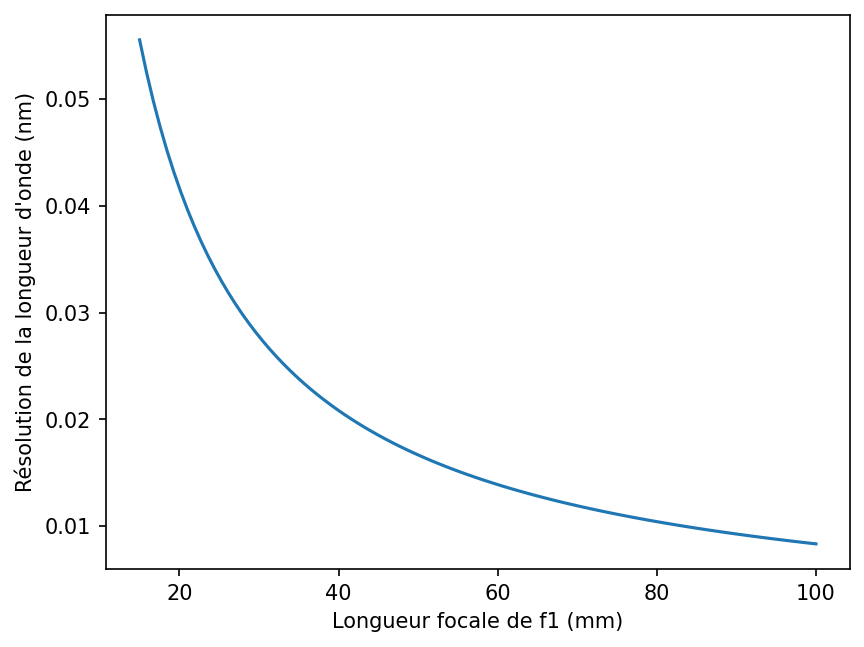

In [447]:
# Résolution
f1_test = np.linspace(15,100,100) # Focales disponibles (mm)
reso = L*Lambda*1e9/f1_test
plt.figure()
plt.plot(f1_test,reso)
plt.xlabel('Longueur focale de f1 (mm)')
plt.ylabel("Résolution de la longueur d'onde (nm)")
plt.show()


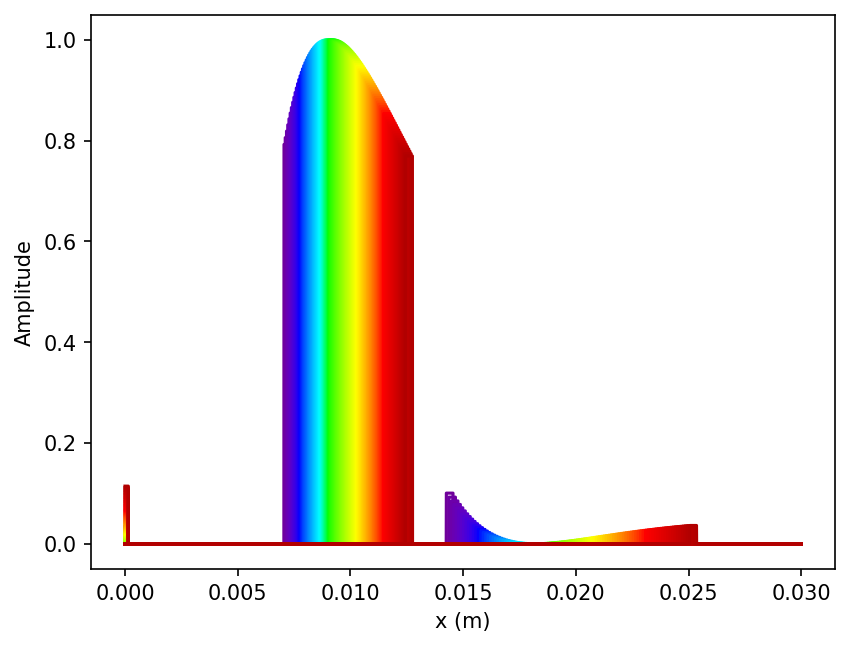

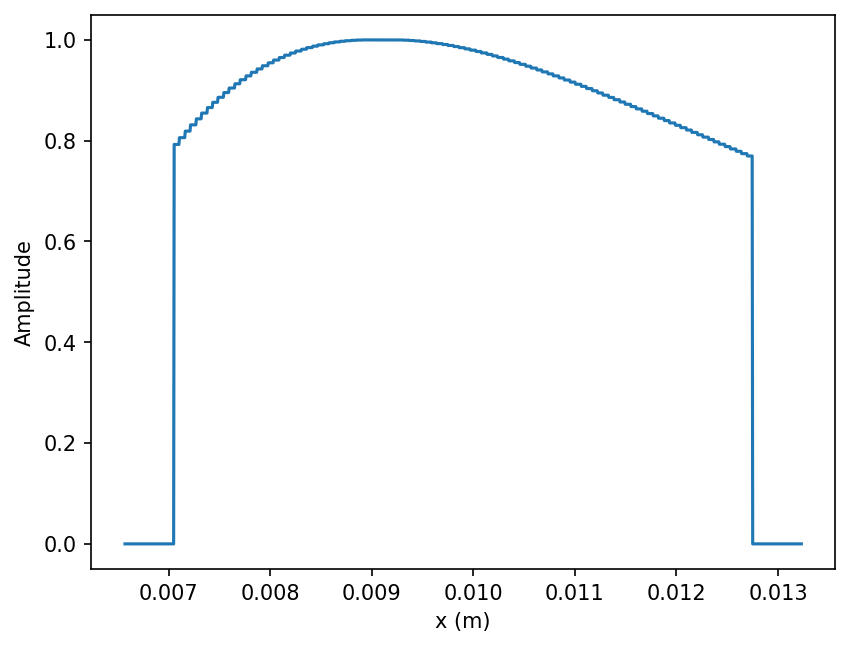

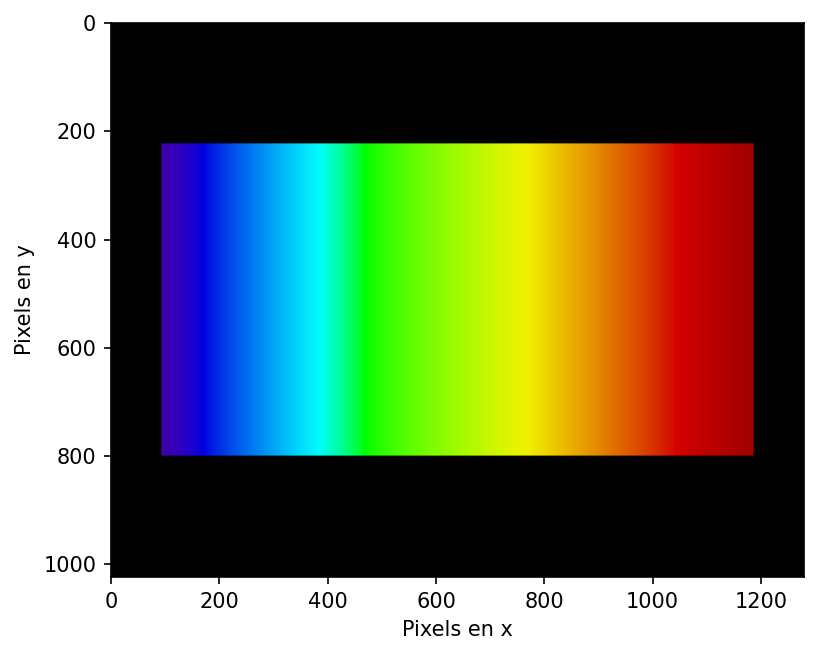

In [448]:
def rect(x, width, shift=0):
    return np.where(np.abs(x - shift) <= width / 2, 1.0, 0.0)

beta = 2*np.tan(theta)/lbd #beta/2pi

x1 = 0 #(m)
x2 = 0.03 #(m)
nb = 10000
width = L*f2/f1  # Width of the rectangle
x = np.linspace(x1, x2, nb)  # Range of x values

lambda_mat = np.zeros((len(lbd),len(x)))
rect_comb_sinc = np.zeros(len(x))
ordre = [-2,-1,0,1,2]


plt.figure()
for n in ordre:
    for i in range(len(lbd)):
        shift = n*lbd[i]*f2/Lambda        
        y = rect(x,width,shift)*np.sinc(n-beta[i]*Lambda)
        rgb = wavelength_to_rgb(lbd[i]*1e9, gamma=0.8)
        plt.plot(x, y**2, color = rgb)
        plt.xlabel('x (m)')
        plt.ylabel('Amplitude')
plt.show()

largeur_cam = 6.66e-3 #(m)
nx_pixels = 1280
ny_pixels = 1024
x_mauve = lbd[0]*f2/Lambda #(m)
x_rouge = lbd[-1]*f2/Lambda #(m)
centre = (x_mauve+x_rouge)/2
x = np.linspace(centre-largeur_cam/2, centre+largeur_cam/2, nx_pixels)  # Range of x values

intensity = np.zeros(len(x))
for n in ordre:
    for i in range(len(lbd)):
        shift = n*lbd[i]*f2/Lambda
        y = rect(x,width,shift)*np.sinc(n-beta[i]*Lambda)
        intensity = np.maximum(intensity,y)
        rgb = wavelength_to_rgb(lbd[i]*1e9, gamma=0.8)
intensity = intensity**2
plt.figure()
plt.plot(x,intensity)
plt.xlabel('x (m)')
plt.ylabel('Amplitude')
plt.show()

color_array = np.zeros((len(x),3))
lbd_vec = np.linspace(400e-9, 700e-9, len(x))
for i in range(len(lbd_vec)):
    color_array[i,:] = wavelength_to_rgb(lbd_vec[i]*1e9, gamma=0.8)

color_array = np.diag(intensity)@color_array
color_array = color_array.reshape((1,len(x),3))
color_array = np.tile(color_array, (ny_pixels, 1, 1))
hauteur_cam = 5.32e-3 #(m)
y = np.linspace(0,hauteur_cam,ny_pixels)
hauteur_fente = 5e-3 #(m)
width_y = hauteur_fente*f2/f1
rect_y = rect(y,width_y,hauteur_cam/2)
rect_y  = rect_y[:, np.newaxis, np.newaxis]
color_array = rect_y*color_array
plt.figure()
plt.imshow(color_array)
plt.xlabel('Pixels en x')
plt.ylabel('Pixels en y')
plt.show()